In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

import os

In [2]:
data = pd.read_csv("spam.csv",encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v1":"label", "v2":"text"})

In [4]:
data.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
data.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [6]:
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

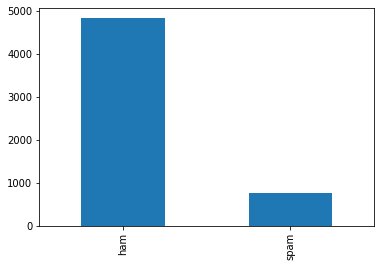

In [7]:
data.label.value_counts().plot.bar();

In [8]:
data['spam'] = data['label'].map( {'spam': 1, 'ham': 0} ).astype(int)
data.head(15)

,label,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


In [9]:
data['length'] = data['text'].apply(len)

In [10]:
data.head(10)

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1,148
6,ham,Even my brother is not like to speak with me. ...,0,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0,160
8,spam,WINNER!! As a valued network customer you have...,1,158
9,spam,Had your mobile 11 months or more? U R entitle...,1,154


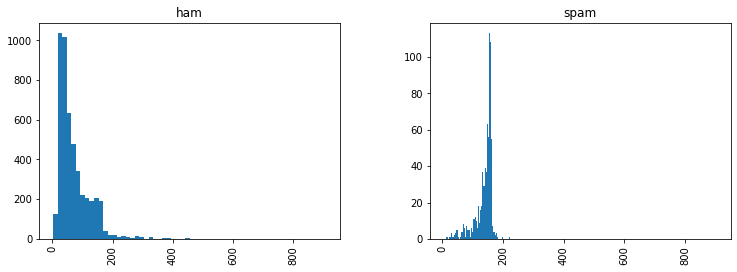

In [11]:
data.hist(column='length',by='label',bins=60,figsize=(12,4));
plt.xlim(-40,950);

In [12]:
data_ham  = data[data['spam'] == 0].copy()
data_spam = data[data['spam'] == 1].copy()

Remove Punctuation and Stopwords

In [13]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/evil_overlord/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
from nltk.corpus import stopwords
stopwords.words("english")[100:110]

['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']

In [16]:
def remove_punctuation_and_stopwords(sms):
    
    sms_no_punctuation = [ch for ch in sms if ch not in string.punctuation]
    sms_no_punctuation = "".join(sms_no_punctuation).split()
    
    sms_no_punctuation_no_stopwords = \
        [word.lower() for word in sms_no_punctuation if word.lower() not in stopwords.words("english")]
        
    return sms_no_punctuation_no_stopwords

In [17]:
data['text'].apply(remove_punctuation_and_stopwords).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

In [18]:
from collections import Counter

In [19]:
data_ham.loc[:, 'text'] = data_ham['text'].apply(remove_punctuation_and_stopwords)
words_data_ham = data_ham['text'].tolist()
data_spam.loc[:, 'text'] = data_spam['text'].apply(remove_punctuation_and_stopwords)
words_data_spam = data_spam['text'].tolist()

In [20]:
list_ham_words = []
for sublist in words_data_ham:
    for item in sublist:
        list_ham_words.append(item)

In [21]:
list_spam_words = []
for sublist in words_data_spam:
    for item in sublist:
        list_spam_words.append(item)

In [22]:
c_ham  = Counter(list_ham_words)
c_spam = Counter(list_spam_words)
df_hamwords_top30  = pd.DataFrame(c_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30 = pd.DataFrame(c_spam.most_common(30), columns=['word', 'count'])

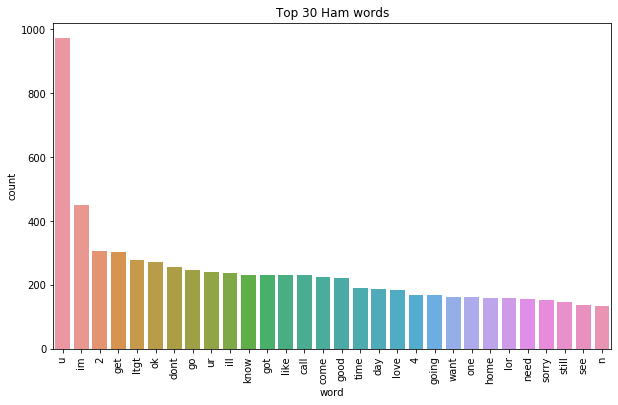

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

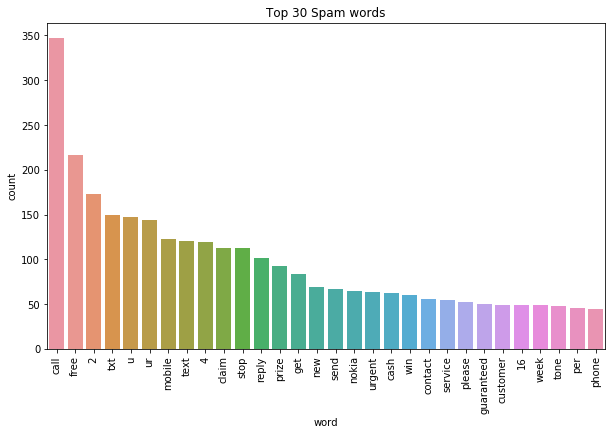

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

BoW Approach

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(data['text'])

In [26]:
print(len(bow_transformer.vocabulary_))

9431


In all sms messages bow_transformer counted 9431 different words.

In [27]:
sample_spam = data['text'][8]
bow_sample_spam = bow_transformer.transform([sample_spam])
print(sample_spam)
print(bow_sample_spam)

WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
  (0, 218)	1
  (0, 323)	1
  (0, 1906)	1
  (0, 2184)	2
  (0, 2245)	1
  (0, 2531)	1
  (0, 4194)	1
  (0, 4759)	1
  (0, 5707)	1
  (0, 6538)	1
  (0, 6775)	1
  (0, 6946)	1
  (0, 7209)	1
  (0, 8694)	1
  (0, 8698)	1
  (0, 9028)	1
  (0, 9418)	1


In [28]:
rows, cols = bow_sample_spam.nonzero()
for col in cols: 
    print(bow_transformer.get_feature_names()[col])

09061701461
12
call
claim
code
customer
hours
kl341
network
prize
receivea
reward
selected
valid
valued
winner
å£900


In [29]:
print(np.shape(bow_sample_spam))

(1, 9431)


In [30]:
sample_ham = data['text'][4]
bow_sample_ham = bow_transformer.transform([sample_ham])
print(sample_ham)
print(bow_sample_ham)

Nah I don't think he goes to usf, he lives around here though
  (0, 1279)	1
  (0, 2882)	1
  (0, 3762)	1
  (0, 5004)	1
  (0, 5631)	1
  (0, 8224)	1
  (0, 8243)	1
  (0, 8664)	1


In [31]:
rows, cols = bow_sample_ham.nonzero()
for col in cols: 
    print(bow_transformer.get_feature_names()[col])

around
dont
goes
lives
nah
think
though
usf


In [32]:
bow_data = bow_transformer.transform(data['text'])

In [33]:
bow_data.shape

(5572, 9431)

In [34]:
bow_data.nnz

49772

In [35]:
#sparse matrix as number of non zero entries are less
bow_data

<5572x9431 sparse matrix of type '<class 'numpy.int64'>'
	with 49772 stored elements in Compressed Sparse Row format>

In [36]:
print( bow_data.nnz / (bow_data.shape[0] * bow_data.shape[1]) *100 )
#nearabout 10% entries are non zero

0.09471444959776236


In [37]:
#tfidf transformer
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(bow_data)

In [38]:
tfidf_sample_ham = tfidf_transformer.transform(bow_sample_ham)
print(tfidf_sample_ham)

  (0, 8664)	0.4000611457714059
  (0, 8243)	0.35462891367407595
  (0, 8224)	0.2665748147939407
  (0, 5631)	0.40493594386802356
  (0, 5004)	0.44910913790937335
  (0, 3762)	0.35674330934716636
  (0, 2882)	0.23016324066220836
  (0, 1279)	0.31179198007951625


In [39]:
tfidf_sample_spam = tfidf_transformer.transform(bow_sample_spam)
print(tfidf_sample_spam)

  (0, 9418)	0.2604683359422661
  (0, 9028)	0.23445094204464131
  (0, 8698)	0.24115248419490207
  (0, 8694)	0.22254833340975305
  (0, 7209)	0.2148462495005997
  (0, 6946)	0.2564029044370425
  (0, 6775)	0.2943229069695555
  (0, 6538)	0.178899142428953
  (0, 5707)	0.2148462495005997
  (0, 4759)	0.2943229069695555
  (0, 4194)	0.22555164191980467
  (0, 2531)	0.1915015107445745
  (0, 2245)	0.21371446699888028
  (0, 2184)	0.3406301232141347
  (0, 1906)	0.1153380143353214
  (0, 323)	0.2387711073538672
  (0, 218)	0.2943229069695555


In [40]:
data_tfidf = tfidf_transformer.transform(bow_data)

In [41]:
data_tfidf

<5572x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 49772 stored elements in Compressed Sparse Row format>

In [42]:
np.shape(data_tfidf)

(5572, 9431)

In [43]:
#train test split
from sklearn.model_selection import train_test_split

data_tfidf_train, data_tfidf_test, label_train, label_test = \
    train_test_split(data_tfidf, data["spam"], test_size=0.3, random_state=5)

In [44]:
data_tfidf_train

<3900x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 35125 stored elements in Compressed Sparse Row format>

In [45]:
data_tfidf_test

<1672x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 14647 stored elements in Compressed Sparse Row format>

In [46]:
data_tfidf_train = data_tfidf_train.A
data_tfidf_test = data_tfidf_test.A

In [47]:
spam_detect_model = MultinomialNB().fit(data_tfidf_train, label_train)
pred_test_MNB = spam_detect_model.predict(data_tfidf_test)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)

0.965311004784689


In [48]:
scaler = MinMaxScaler()
data_tfidf_train_sc = scaler.fit_transform(data_tfidf_train)
data_tfidf_test_sc  = scaler.transform(data_tfidf_test)

In [49]:
spam_detect_model_minmax = MultinomialNB().fit(data_tfidf_train_sc, label_train)
pred_test_MNB = spam_detect_model_minmax.predict(data_tfidf_test_sc)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)

0.9826555023923444
